In [3]:
import matplotlib as mpl
import numpy as np
from matplotlib.font_manager import FontProperties

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 设置中文字体
# 方法1：使用系统中已有的中文字体
fonts = [f.name for f in fm.fontManager.ttflist if '微软雅黑' in f.name or 'SimHei' in f.name or 'SimSun' in f.name or 'Microsoft YaHei' in f.name]
if fonts:
    plt.rcParams['font.family'] = fonts[0]
    print(f"使用字体: {fonts[0]}")
else:
    # 方法2：使用matplotlib内置的中文字体支持
    plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    print("使用默认中文字体配置")

使用字体: Microsoft YaHei


# 模型评估

在本Notebook中，我们将对训练好的MNIST模型进行评估，比较使用Adam和SGD优化器训练的模型的性能。

使用设备: cpu
Successfully downloaded MNIST dataset using torchvision
Test accuracy: 99.04%


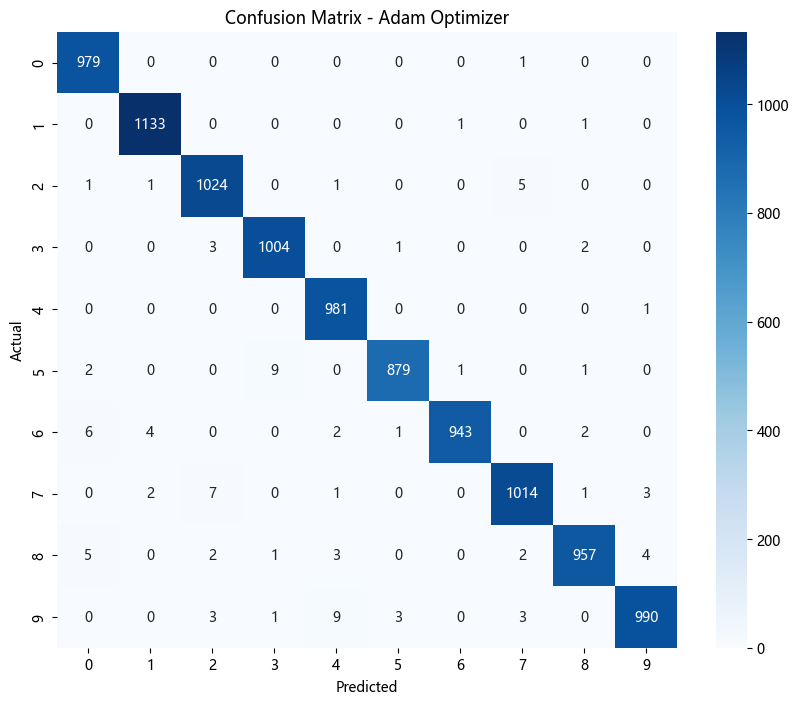

Successfully downloaded MNIST dataset using torchvision
Test accuracy: 98.17%


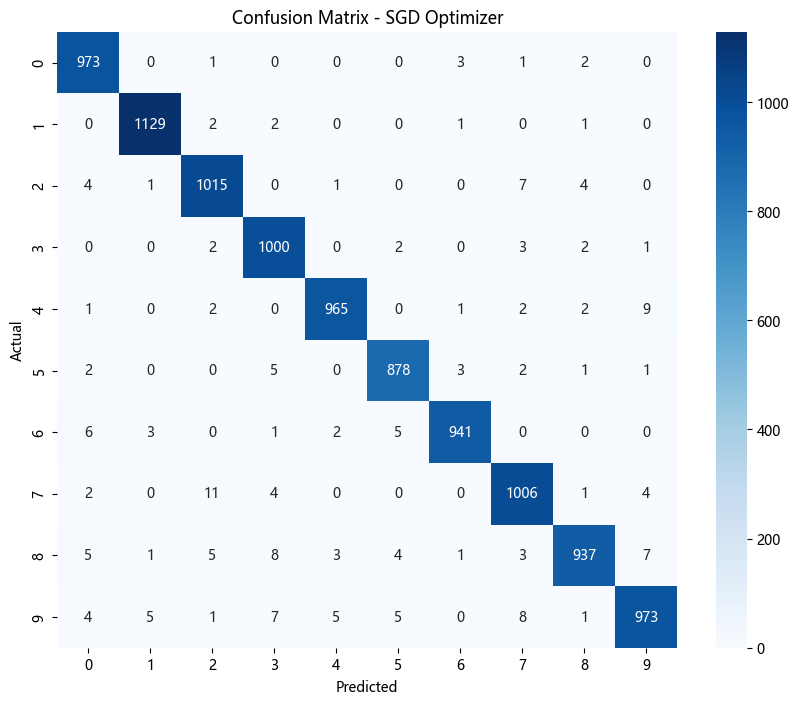


优化器性能对比:
Adam优化器准确率: 99.04%
SGD优化器准确率: 98.17%
准确率差异 (Adam - SGD): 0.87%


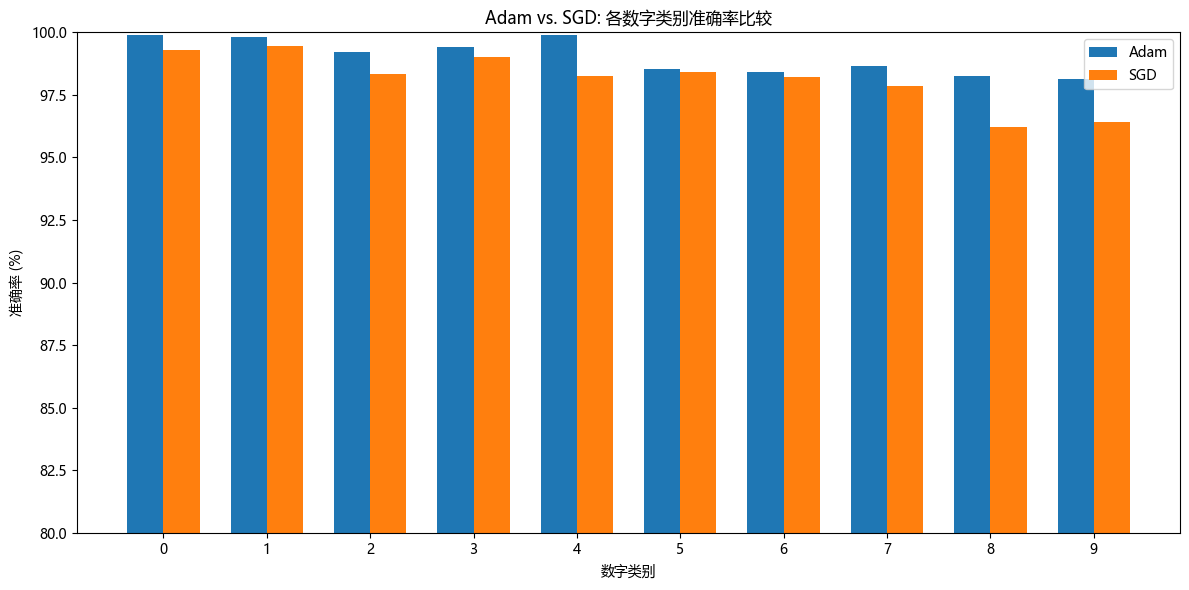

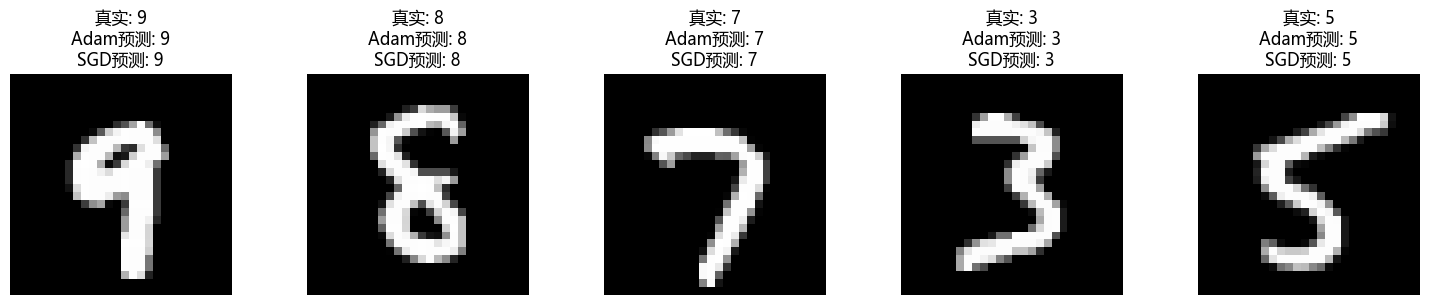

In [4]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import sys

# 添加项目根目录到路径
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

# 导入顺序很重要，确保Python能找到模块
from src.models.mnist_cnn import MNIST_CNN
from src.test_model import test_model

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 数据预处理
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 加载测试数据集（从项目根目录的data文件夹）
data_dir = os.path.join(project_root, "data")
test_dataset = datasets.MNIST(data_dir, train=False, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 构建模型路径（使用项目根目录的saved_models文件夹）
saved_models_dir = os.path.join(project_root, "saved_models")
adam_model_path = os.path.join(saved_models_dir, "mnist_Adam.pt")
sgd_model_path = os.path.join(saved_models_dir, "mnist_SGD.pt")

# 测试Adam优化器模型
adam_model, adam_accuracy, adam_predictions, adam_true_labels, adam_conf_mat = test_model(adam_model_path, "Adam")

# 测试SGD优化器模型
sgd_model, sgd_accuracy, sgd_predictions, sgd_true_labels, sgd_conf_mat = test_model(sgd_model_path, "SGD")

# 比较两个模型的性能
print("\n优化器性能对比:")
print(f"Adam优化器准确率: {adam_accuracy:.2f}%")
print(f"SGD优化器准确率: {sgd_accuracy:.2f}%")
print(f"准确率差异 (Adam - SGD): {adam_accuracy - sgd_accuracy:.2f}%")

# 可视化对比不同类别的准确率
def compare_class_accuracy(adam_conf, sgd_conf):
    adam_class_acc = [adam_conf[i,i]/np.sum(adam_conf[i])*100 for i in range(10)]
    sgd_class_acc = [sgd_conf[i,i]/np.sum(sgd_conf[i])*100 for i in range(10)]
    
    plt.figure(figsize=(12, 6))
    x = np.arange(10)
    width = 0.35
    
    plt.bar(x - width/2, adam_class_acc, width, label='Adam')
    plt.bar(x + width/2, sgd_class_acc, width, label='SGD')
    
    plt.xlabel('数字类别')
    plt.ylabel('准确率 (%)')
    plt.title('Adam vs. SGD: 各数字类别准确率比较')
    plt.xticks(x, range(10))
    plt.ylim(80, 100)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 比较各类别准确率
compare_class_accuracy(adam_conf_mat, sgd_conf_mat)

# 可视化一些测试样例(同时显示两个模型的预测结果)
def visualize_samples_comparison(adam_model, sgd_model, device, test_loader, num_samples=5):
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    sample_indices = torch.randint(0, len(images), (num_samples,))
    sample_images = images[sample_indices].to(device)
    sample_labels = labels[sample_indices]
    
    adam_outputs = adam_model(sample_images)
    _, adam_predicted = torch.max(adam_outputs, 1)
    
    sgd_outputs = sgd_model(sample_images)
    _, sgd_predicted = torch.max(sgd_outputs, 1)
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(sample_images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"真实: {sample_labels[i]}\nAdam预测: {adam_predicted[i].cpu().item()}\nSGD预测: {sgd_predicted[i].cpu().item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples_comparison(adam_model, sgd_model, device, test_loader)